# Information
## Source
This notebook prepares the data from Lawley et al. (2022) for categoricals and but for numericals, the uninfied data from McCafferty (2023) will be used.

## General workflow
1. Create a file list of the data files from different source folders needed for modeling
2. Read the rasters and convert them into a dataframe with column names acording to the file names
3. Check outliers for each numerial column and set those to the nearest value within the 1.5 IQR range
4. Impute (basic imputation to get some progress, but not very suitable for spatial data)<br>
4.1 Numerical columns (mean)<br>
4.2 Categorical columns (zeros)<br>
6. Scale the data (numerical columns only)
7. Add the mask based on the base raster and remove the rows with missing values
8. Prepare data for modeling:
   - Split the data into train and test sets
   - Sample data
9. Train and evaluate the model
10. Predict on full dataset (imputed, scaled)

# Set up

In [4]:
from importlib_resources import files
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gc

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from collections import Counter

import sys, os, warnings
from pathlib import Path
from importlib_resources import files

# Custom modules
from beak.utilities.io import load_model, save_raster, check_path
from beak.utilities.eda import clip_outliers
from beak.utilities.preparation import impute_data
from beak.utilities.transformation import _scale_data
from beak.models import tungsten_skarn_nat                   # Includes the model definitions used in this notebook 

BASE_PATH = files("beak.data")
gc.enable()

scaler_type = "standard"
seed = 42


**User** inputs

In [5]:
# Choose model
MODEL = "TUNGSTEN_SKARN_V1"
model = tungsten_skarn_nat.models[MODEL]

BASE_SPATIAL = "EPSG_4326_RES_0_025"
BASE_EXTENT = "CLIPPED_USC"

PATH_ML_MODELS = Path("models")
check_path(PATH_ML_MODELS)

PATH_MODEL_RESULTS = Path("exports")
check_path(PATH_MODEL_RESULTS)

PATH_TRAIN_LOGS = Path("logs")
check_path(PATH_TRAIN_LOGS)

PATH_NUMERICAL_LAWLEY = BASE_PATH / "LAWLEY22-EXPORT" / BASE_SPATIAL / BASE_EXTENT / "NUMERICAL"
PATH_NUMERICAL_MCCAFFERTY = BASE_PATH / "MCCAFFERTY23-PROCESSED" / BASE_SPATIAL / BASE_EXTENT / "GEOPHYSICS"
PATH_NUMERICAL_ISOGRAVITY = BASE_PATH / "ISOGRAVITY-PROCESSED" / BASE_SPATIAL / BASE_EXTENT / "UNIFIED"
PATH_NUMERICAL_AERORADIOMETRY = BASE_PATH / "AERORADIOMETRICS-PROCESSED" / BASE_SPATIAL / BASE_EXTENT / "USGS" / "UNIFIED"

PATH_CATEGORICAL = BASE_PATH / "LAWLEY22-EXPORT" / BASE_SPATIAL / BASE_EXTENT / "CATEGORICAL"
PATH_BASE_RASTER = BASE_PATH / "BASE_RASTERS" / "EPSG_4326_RES_0_025_CLIPPED_USC.tif" 
PATH_LABELS = BASE_PATH / "TRAINING_LABELS" / "TUNGSTEN_SKARN_EPSG_4326_RES_0_025_CLIPPED_USC.tif"

LABELS_COL = "LABELS"
BASE_RASTER_COL = "BASE_RASTER"

# 0: Functions

## General

**Save** and **load** models

In [6]:
def save_ml_model(model, model_name, path=PATH_ML_MODELS):
  """Saves model to disk"""
  model.save(path / str(model_name + ".keras"))
  

def load_ml_model(model_name, path=PATH_ML_MODELS):
  """Loads model from disk"""
  return keras.models.load_model(path + model_name + ".keras")

**Create** callbacks

In [7]:
import datetime

def tensorboard_callback(folder, model_name):
  log_dir = os.path.join(folder, model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  training_log = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return training_log


## Subsetting data and sampling

**Oversampling** the initial data with simple oversampling

In [8]:
from imblearn.over_sampling import RandomOverSampler

def oversample_data(X, y, sampling_strategy=0.5, random_state=seed, shrinkage=0.0):
  ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed, shrinkage=shrinkage)
  X_ros, y_ros = ros.fit_resample(X, y)
  print(f"Resampled dataset shape {Counter(y_ros)}, positive/negative ratio: {round(Counter(y_ros)[1] / Counter(y_ros)[0], 2)}")
  
  return X_ros.astype(np.float32), y_ros.astype(np.int8)


**Create** subsets

In [9]:
def create_subsets(X, y, num_downsampling, ground_truth=LABELS_COL, seed=seed):
  Xy = pd.concat([X, y], axis=1)
  Xy_subset = Xy.sample(n=num_downsampling, random_state=seed)

  X_subset = Xy_subset.drop(columns=[ground_truth], inplace=False)
  y_subset = Xy_subset[ground_truth]
  print(f"Subset dataset shape {Counter(y_subset)}")

  return X_subset, y_subset


def select_random_samples(X, y, sampling_strategy=0.1, sampling_class="negatives", seed=seed):
  X_positives = X[y == 1] 
  X_negatives = X[y == 0]

  X_samples = X_negatives if sampling_class == "negatives" else X_positives
  X_samples = X_samples.sample(frac=sampling_strategy, random_state=seed, replace=False)

  X_positives = X_samples if sampling_class == "positives" else X_positives
  X_negatives = X_samples if sampling_class == "negatives" else X_negatives
  
  X_samples = pd.concat([X_positives, X_negatives], axis=0)
  y_samples = np.concatenate([np.ones(X_positives.shape[0]), np.zeros(X_negatives.shape[0])])

  print(f"Subset dataset shape {Counter(y_samples)}")
  return X_samples, y_samples


In [10]:
def create_number_of_random_negatives(X, y, multiplier=20):
  y_positives = y[y == 1]
  random_num_negatives = len(y_positives) * multiplier
  ratio = round(random_num_negatives / len(X), 3)
  return ratio


## Create models

**Building** and **training** ANN models

In [11]:
def train_ann(X, 
              y,
              model,
              validation_data=None, 
              validation_split=0.2,  
              validation_steps=None,
              epochs=100, 
              batch_size=32, 
              optimizer=tf.keras.optimizers.Adam, 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=["mse"], 
              callbacks=[], 
              verbose=0,
              seed=42,
              mixed_precision=False):
  """Train ANN model"""
  # Set mixed precision policy
  if mixed_precision is True:
    tf.keras.mixed_precision.set_global_policy(policy='mixed_float16')
  else:
    tf.keras.mixed_precision.set_global_policy(policy='float32')

  tf.random.set_seed(seed)  

  # Print settings
  print(f"Random seed: {seed}, precision: {tf.keras.mixed_precision.global_policy().name}\n")
  
  if validation_data:
    print(f"Training on {X.shape[0]} samples.\n")
  else:
    print(f"Training on {int(X.shape[0] - X.shape[0] * validation_split)} samples.\n")
    
  model.compile(optimizer=optimizer(learning_rate=0.001), loss=loss, metrics=metrics)
  return model.fit(X, y, validation_data=validation_data, validation_split=validation_split, validation_steps=validation_steps, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
    

Simple initial **ANN**

In [12]:
# Simple initial ANN model
def create_simple_ann(num_features, model_name="ANN", hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=42):
  """Create a new ANN model"""  
  tf.random.set_seed(seed)
  neurons = num_features*2 + 1

  input = tf.keras.Input(shape=(num_features,), name="Input_layer")
  x = layers.Dense(neurons, activation=activation, name="Hidden_layer_1")(input)
  x = layers.BatchNormalization()(x) if batch_norm is True else x
  
  if hidden_units > 1:
    for i in range(1, hidden_units):
      hidden_unit_name = f"Hidden_layer_{i+1}"
      x = layers.Dense(neurons, activation=activation, name=hidden_unit_name)(x)
      x = layers.BatchNormalization()(x) if batch_norm is True else x  
       
  output = layers.Dense(1, activation=tf.keras.activations.sigmoid, dtype=tf.float32, name="Output_layer")(x)
  return tf.keras.Model(inputs=input, outputs=output, name=model_name)


**C1: Complex** ANN with ascending order of neurons to the power of 2

In [13]:
# Create complex ANN models
def create_ann_c1(num_features, model_name="ANN", min_exp=6, hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=42):
  """Create a new ANN model"""  
  tf.random.set_seed(seed)

  neurons = 2**min_exp
  input = tf.keras.Input(shape=(num_features,), name="Input_layer")
  x = layers.Dense(2**min_exp, activation=activation, name="Hidden_layer_1")(input)
  x = layers.BatchNormalization()(x) if batch_norm is True else x
  
  if hidden_units > 1:
    for i in range(1, hidden_units):
      neurons = 2**(min_exp + i)
      hidden_unit_name = f"Hidden_layer_{i+1}"
      x = layers.Dense(neurons, activation=activation, name=hidden_unit_name)(x)
      x = layers.BatchNormalization()(x) if batch_norm is True else x  
       
  output = layers.Dense(1, activation=tf.keras.activations.sigmoid, dtype=tf.float32, name="Output_layer")(x)
  return tf.keras.Model(inputs=input, outputs=output, name=model_name)
  

**C2: Complex** ANN with descending order of neurons to the power of 2

In [14]:
# Create complex ANN models
def create_ann_c2(num_features, model_name="ANN", max_exp=12, hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=42):
  """Create a new ANN model"""  
  tf.random.set_seed(seed)

  neurons = 2**max_exp
  input = tf.keras.Input(shape=(num_features,), name="Input_layer")
  x = layers.Dense(2**max_exp, activation=activation, name="Hidden_layer_1")(input)
  x = layers.BatchNormalization()(x) if batch_norm is True else x
  
  if hidden_units > 1:
    for i in range(1, hidden_units):
      neurons = neurons - 2**(max_exp - i)
      hidden_unit_name = f"Hidden_layer_{i+1}"
      x = layers.Dense(neurons, activation=activation, name=hidden_unit_name)(x)
      x = layers.BatchNormalization()(x) if batch_norm is True else x  
      
      if neurons == 2:
        print(f"Neurons: {neurons}, minumum reached!")
        break
      
  output = layers.Dense(1, activation=tf.keras.activations.sigmoid, dtype=tf.float32, name="Output_layer")(x)
  return tf.keras.Model(inputs=input, outputs=output, name=model_name)
  

## **Evaluation**

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
  
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Function')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show();


def eval_roc_auc(model, X, y, plot=True, batch_size=1024):
  """Evaluate ROC AUC score"""
  # ROC AUC score
  y_pred = model.predict(X, verbose=0, batch_size=batch_size)
  eval_roc_auc = roc_auc_score(y, y_pred)
  
  # ROC curve
  if plot is True:
    fpr, tpr, _ = roc_curve(y, y_pred)
    
    # Plotting
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {eval_roc_auc:.4})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
  else:
    print(f"ROC AUC score: {eval_roc_auc:.4}")
    
  return eval_roc_auc


def plot_loss_and_roc(history, model, X, y, batch_size=1024):
  """Plot loss and ROC curve
  
  Example usage:
  Assuming 'history' is the training history and 'model' is your trained model
  Replace X and y with your actual data and call  plot_loss_and_roc(history, model, X, y)
  
  """
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Function')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Evaluate ROC AUC and plot ROC curve
  plt.subplot(1, 2, 2)
  y_pred = model.predict(X, verbose=0, batch_size=batch_size)
  fpr, tpr, _ = roc_curve(y, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.4})")
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")

  plt.tight_layout(pad=3) 
  plt.show()



## **Prediction**


In [16]:
def set_nodata(data, prediction, columns):
  out_nodata = -9999.
  
  nan_mask = np.isnan(data[columns]).to_numpy()
  nan_mask = np.max(nan_mask, axis=1)
  nan_mask = nan_mask.reshape(-1, 1)
  
  return np.where(nan_mask, out_nodata, prediction)  


def predict_values(data, model_columns, model, batch_size=512, verbose=1, impute=True,  setback_nodata=False):
  assert not (impute and setback_nodata), "Imputing and setting back nodata is not possible at the same time!"
    
  if impute is True and setback_nodata is False:
    data = impute_data(data, columns=model_columns)

  prediction = model.predict(data[model_columns], batch_size=batch_size, verbose=verbose)
  
  if setback_nodata is True and impute is False:
    out_data = set_nodata(data, prediction, columns=model_columns) if impute is False else prediction
  else:
    out_data = prediction
    
  return out_data
  

## Data

**Create** training data 

In [17]:
def create_train_test_splits(X, y, test_size=0.2, seed=seed, out_dtype=np.float32, out_type="tensorflow"):
  """Create training and testing data"""
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
  
  if out_type == "tensorflow":
    X_train = tf.convert_to_tensor(X_train, dtype=out_dtype)
    X_test = tf.convert_to_tensor(X_test, dtype=out_dtype)
    y_train = tf.convert_to_tensor(y_train, dtype=np.int8)
    y_test = tf.convert_to_tensor(y_test, dtype=np.int8)
  elif out_type == "numpy":
    X_train = X_train.astype(out_dtype)
    X_test = X_test.astype(out_dtype)
    y_train = y_train.astype(np.int8)
    y_test = y_test.astype(np.int8)
    
  return X_train, X_test, y_train, y_test

## Normalization

# 1: **Create** file list

In [18]:
model_dict, file_list, counts = load_model(
    model=model,
    folders=[PATH_NUMERICAL_LAWLEY, PATH_NUMERICAL_MCCAFFERTY, PATH_NUMERICAL_ISOGRAVITY, PATH_NUMERICAL_AERORADIOMETRY, PATH_CATEGORICAL],
    file_extensions=[".tif", ".tiff"],
    verbose=0,
)    

print(f"\nRelevant files found: {len(file_list)}")

pd.options.display.float_format = "{:.3f}".format
seed = 42  
scaler_type = "standard"

Loading model definition...
Selected 35 evidence layers.

Searching for files and folders in provided paths...
Found 5 folders, 43 subfolders and 832 files.

Searching for corresponding files...
Found 'Geology_Lithology_Majority' in 31 file(s).
Found 'Geology_Lithology_Minority' in 31 file(s).
Found 'Geology_Period_Maximum_Majority' in 20 file(s).
Found 'Geology_Period_Minimum_Majority' in 20 file(s).
Found 'Geology_Dictionary_Calcareous' in 1 file(s).
Found 'Geology_Dictionary_Carbonaceous' in 1 file(s).
Found 'Geology_Dictionary_FineClastic' in 1 file(s).
Found 'Geology_Dictionary_Felsic' in 1 file(s).
Found 'Geology_Dictionary_Intermediate' in 1 file(s).
Found 'Geology_Dictionary_UltramaficMafic' in 1 file(s).
Found 'Geology_Dictionary_Anatectic' in 1 file(s).
Found 'Geology_Dictionary_Gneissose' in 1 file(s).
Found 'Geology_Dictionary_Schistose' in 1 file(s).
Found 'Terrane_Proximity' in 1 file(s).
Found 'Geology_PassiveMargin_Proximity' in 1 file(s).
Found 'Geology_BlackShale_Prox

# 2: **Load** data

In [22]:
data = []
numerical_columns = []
categorical_columns = []

for raster_file in tqdm(file_list):
    # Extract the file name without extension
    column_name = raster_file.stem
    
    raster = rasterio.open(raster_file)
    if "float" in raster.meta["dtype"]:
        numerical_columns.append(column_name)
    elif "int" in raster.meta["dtype"]:
        categorical_columns.append(column_name)
    
    raster_data = raster.read(1).reshape(-1, 1)
    raster_data = np.where(raster_data == raster.nodata, np.nan, raster_data)
    
    df = pd.DataFrame(raster_data, columns=[column_name])
    data.append(df)
    del df
    
# Concatenate all dataframes in the data list into a single dataframe
df_rasters = pd.concat(data, axis=1)

print(f"Found {len(numerical_columns)} numerical columns and {len(categorical_columns)} categorical columns.")


100%|██████████| 133/133 [00:03<00:00, 36.45it/s]


Found 22 numerical columns and 111 categorical columns.


In [24]:
# Base raster
base_raster = rasterio.open(PATH_BASE_RASTER)
base_raster_array = base_raster.read(1)
base_raster_array = np.where(base_raster_array == base_raster.nodata, np.nan, base_raster_array)

In [25]:
# Labels raster
labels_raster = rasterio.open(PATH_LABELS)
labels_array = labels_raster.read(1)
labels_array = np.where(labels_array == labels_raster.nodata, np.nan, labels_array)

# 3: **Remove** outliers

In [26]:
df_outliers = clip_outliers(df_rasters, numerical_columns)

# 4: **Impute** missing values

## Numerical columns

In [27]:
df_impute = impute_data(df_outliers, numerical_columns)


## Categorical columns

In [28]:
df_impute = impute_data(df_impute, categorical_columns, strategy="constant", fill_value=0)

# 5: **Scaling**

In [29]:
df_scaled = _scale_data(df_impute, scaler_type, numerical_columns)


# 6: **Add** mask and remove rows with missing values
Shape the correct spatial extent and outline of the data

In [30]:
df_model = df_scaled.copy()
df_model = pd.concat([df_model, pd.DataFrame(labels_array.reshape(-1, 1), columns=["LABELS"])], axis=1)

df_model.dropna(how="any", inplace=True)
print(f"Data rows for all values: {df_model.shape[0]}, data columns: {df_model.shape[1]}")

num_negatives = df_model[df_model[LABELS_COL] == 0].shape[0]
print("\nData rows for Absent values:", num_negatives)

num_positives = df_model[df_model[LABELS_COL] == 1].shape[0]
print("Data rows for Present values:", num_positives)

Data rows for all values: 1336302, data columns: 134

Data rows for Absent values: 1336245
Data rows for Present values: 57


# 7: **Prepare** for modeling

## **Subset** data

In [31]:
X = df_model.drop(columns=[LABELS_COL], inplace=False)
y = df_model[LABELS_COL]

### **Create** positive/negative subsets

In [32]:
# Create selection of the positives and negatives for testing purposes
X_positives = df_model[df_model[LABELS_COL] == 1].drop(columns=[LABELS_COL], inplace=False).astype(np.float32)
y_positives = df_model[df_model[LABELS_COL] == 1][LABELS_COL].astype(np.float32)

# **Modeling**

**Test model M2F-I:** Train/test split first, afterwards oversampling without Batch Norm but with lower random sample ratio at the beginning

In [33]:
downsample_ratio = create_number_of_random_negatives(X, y, multiplier=20)
X_rs, y_rs = select_random_samples(X, y, sampling_strategy=downsample_ratio, sampling_class="negatives", seed=seed)
X_train, X_test, y_train, y_test = create_train_test_splits(X_rs, y_rs, test_size=0.2)
X_rs_ros, y_rs_ros = oversample_data(X_rs, y_rs, sampling_strategy=0.5, random_state=seed, shrinkage=0.0)

print(f"Training dataset shape {Counter(y_rs_ros)}")
print(f"Test dataset shape {Counter(y_test.numpy())}")

X_train = tf.convert_to_tensor(X_rs_ros, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_rs_ros, dtype=tf.int8)

Subset dataset shape Counter({0.0: 1336, 1.0: 57})
Resampled dataset shape Counter({0.0: 1336, 1.0: 668}), positive/negative ratio: 0.5
Training dataset shape Counter({0: 1336, 1: 668})
Test dataset shape Counter({0: 268, 1: 11})


In [34]:
epochs = 50
batch_size = 512

model_name = "USC_V1_ANN_M2F_I_" + str(epochs) + "_EPOCHS_" + str(batch_size) + "_BATCH_SIZE"


In [35]:
model = create_simple_ann(num_features=X_train.shape[1], model_name=model_name, hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=seed)
callbacks = [
             # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5), 
             tensorboard_callback(PATH_TRAIN_LOGS, model_name)
             ]

train_results = train_ann(X_train, y_train, model, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks, seed=seed, verbose=0)


Saving TensorBoard log files to: logs\USC_V1_ANN_M2F_I_50_EPOCHS_512_BATCH_SIZE_20240211-212357
Random seed: 42, precision: float32

Training on 1603 samples.



In [36]:
# Save model
save_ml_model(model, model_name)

In [ ]:
# Load model
# model  = load_ml_model(model_name)


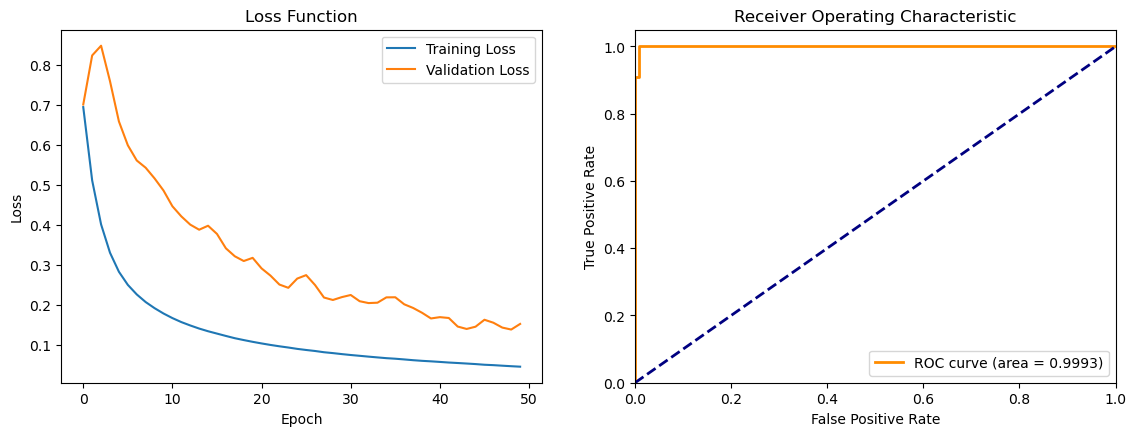

1/1 [==============================] - 0s 20ms/step - loss: 0.2318 - mse: 0.0637

Eval - Test loss: 0.02857, Test metric: 0.006257
Eval positives only- Test loss: 0.2318, Test metric: 0.06371


In [37]:
# Plot loss and roc curve
plot_loss_and_roc(train_results, model, X_test, y_test, batch_size=512)

# Evaluation
# Test (with oversampled data)
eval = model.evaluate(X_test, y_test, batch_size=512)

# Test (with oversampled data, only positives)
eval_positives = model.evaluate(X_test[y_test==1], y_test[y_test==1], batch_size=512)

print(f"\nEval - Test loss: {eval[0]:.4}, Test metric: {eval[1]:.4}")
print(f"Eval positives only- Test loss: {eval_positives[0]:.4}, Test metric: {eval_positives[1]:.4}")


In [38]:
prediction = predict_values(df_scaled, df_scaled.columns.tolist(), model, batch_size=512)


4687/4687 [==============================] - 9s 2ms/step


In [42]:
prediction = prediction.reshape(base_raster_array.shape)
prediction = np.where(np.isnan(base_raster_array), np.nan, prediction)

out_path = PATH_MODEL_RESULTS / str(model_name + ".tif")
save_raster(out_path, array=prediction, dtype="float32", metadata=base_raster.meta)   
